In [ ]:
!pip install transformers


In [ ]:
from transformers import BertModel, BertTokenizer
import pandas as pd
import torch


In [ ]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.7 MB/s eta 0:00:00


### Visualizations


In [ ]:
import pandas as pd
import requests
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from tqdm import tqdm

# Paths
input_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_targets.csv"
output_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/protein_sequences.csv"
output_fasta = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"
missing_proteins_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_proteins.csv"

# Load `updated_drug_targets.csv`
drug_targets_df = pd.read_csv(input_file)
protein_ids = drug_targets_df["protein_id"].unique()

# Function to fetch protein sequences from UniProt
def fetch_uniprot_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        sequence = "".join(fasta_data.split("\n")[1:])  # Combine sequence lines
        return sequence
    return None

# Function to fetch protein sequences from NCBI
def fetch_ncbi_sequence(protein_id):
    url = f"https://www.ncbi.nlm.nih.gov/protein/{protein_id}"
    response = requests.get(url)
    if response.status_code == 200 and "sequence" in response.text.lower():
        sequence_start = response.text.lower().find("sequence") + 9
        sequence = response.text[sequence_start:].split("<")[0].strip()
        return sequence
    return None

# Validate sequences
def is_valid_sequence(sequence):
    if not sequence:
        return False
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
    return all(c in valid_amino_acids for c in sequence)

# Fetch and validate sequences
protein_data = []
fasta_records = []
missing_proteins = []

for protein_id in tqdm(protein_ids, desc="Fetching protein sequences"):
    sequence = fetch_uniprot_sequence(protein_id)  # Try UniProt
    if not sequence:
        sequence = fetch_ncbi_sequence(protein_id)  # Fallback to NCBI
    if sequence and is_valid_sequence(sequence):  # Validate the sequence
        protein_data.append({"protein_id": protein_id, "sequence": sequence})
        fasta_records.append(SeqRecord(Seq(sequence), id=protein_id, description=""))
    else:
        missing_proteins.append({"protein_id": protein_id, "sequence": sequence})

# Save valid protein sequences to CSV
protein_df = pd.DataFrame(protein_data)
protein_df.to_csv(output_csv, index=False)
print(f"Valid protein sequences saved to: {output_csv}")

# Save valid protein sequences to FASTA
with open(output_fasta, "w") as fasta_out:
    SeqIO.write(fasta_records, fasta_out, "fasta")
print(f"Cleaned protein sequences saved to: {output_fasta}")

# Save missing protein IDs to CSV
if missing_proteins:
    missing_df = pd.DataFrame(missing_proteins)
    missing_df.to_csv(missing_proteins_csv, index=False)
    print(f"Missing protein IDs saved to: {missing_proteins_csv}")
else:
    print("No missing protein IDs!")


Fetching protein sequences: 100%|██████████| 4906/4906 [1:41:00<00:00,  1.24s/it]


Valid protein sequences saved to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/protein_sequences.csv
Cleaned protein sequences saved to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta
Missing protein IDs saved to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_proteins.csv


In [ ]:
import pandas as pd
import requests
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from tqdm import tqdm

# Paths
missing_proteins_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_proteins.csv"
output_fasta = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"
new_missing_proteins_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/new_missing_proteins.csv"

# Load missing proteins
missing_proteins_df = pd.read_csv(missing_proteins_csv)
missing_protein_ids = missing_proteins_df["protein_id"].unique()

# Function to fetch protein sequences from UniProt
def fetch_uniprot_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        sequence = "".join(fasta_data.split("\n")[1:])  # Combine sequence lines
        return sequence
    return None

# Function to fetch protein sequences from NCBI
def fetch_ncbi_sequence(protein_id):
    url = f"https://www.ncbi.nlm.nih.gov/protein/{protein_id}"
    response = requests.get(url)
    if response.status_code == 200 and "sequence" in response.text.lower():
        sequence_start = response.text.lower().find("sequence") + 9
        sequence = response.text[sequence_start:].split("<")[0].strip()
        return sequence
    return None

# Validate sequences
def is_valid_sequence(sequence):
    if not sequence:
        return False
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")  # Standard amino acids
    valid_amino_acids.add("U")  # Include selenocysteine
    return all(c in valid_amino_acids for c in sequence)

# Recheck missing proteins
new_fasta_records = []
still_missing_proteins = []

for protein_id in tqdm(missing_protein_ids, desc="Rechecking missing proteins"):
    sequence = fetch_uniprot_sequence(protein_id)  # Try UniProt
    if not sequence:
        sequence = fetch_ncbi_sequence(protein_id)  # Fallback to NCBI
    if sequence and is_valid_sequence(sequence):  # Validate the sequence
        new_fasta_records.append(SeqRecord(Seq(sequence), id=protein_id, description=""))
    else:
        still_missing_proteins.append({"protein_id": protein_id, "sequence": sequence})

# Append all valid sequences (including those with `U`) to the existing FASTA file
if new_fasta_records:
    with open(output_fasta, "a") as fasta_out:  # Append mode
        SeqIO.write(new_fasta_records, fasta_out, "fasta")
    print(f"Appended {len(new_fasta_records)} new sequences to: {output_fasta}")

# Save the updated list of missing proteins
if still_missing_proteins:
    still_missing_df = pd.DataFrame(still_missing_proteins)
    still_missing_df.to_csv(new_missing_proteins_csv, index=False)
    print(f"Updated missing proteins saved to: {new_missing_proteins_csv}")
else:
    print("All missing proteins have been resolved!")


Rechecking missing proteins: 100%|██████████| 29/29 [00:46<00:00,  1.61s/it]

Appended 11 new sequences to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta
Updated missing proteins saved to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/new_missing_proteins.csv


In [ ]:
import pandas as pd
import requests
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from tqdm import tqdm
import time

# Paths
missing_proteins_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/new_final_unresolved_proteins.csv"
output_fasta = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"
final_unresolved_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_final_unresolved_proteins.csv"

# Load new missing proteins
missing_proteins_df = pd.read_csv(missing_proteins_file)
protein_ids = missing_proteins_df["protein_id"].unique()  # Get unique protein IDs

# Function to fetch sequence from UniProt
def fetch_uniprot_sequence(protein_id):
    url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        sequence = "".join(fasta_data.split("\n")[1:])  # Combine sequence lines
        return sequence
    return None

# Function to fetch sequence from NCBI
def fetch_ncbi_sequence(protein_id):
    url = f"https://www.ncbi.nlm.nih.gov/protein/{protein_id}"
    response = requests.get(url)
    if response.status_code == 200 and "sequence" in response.text.lower():
        sequence_start = response.text.lower().find("sequence") + 9
        sequence = response.text[sequence_start:].split("<")[0].strip()
        return sequence
    return None

# Validate sequences (accept `X` as valid)
def is_valid_sequence(sequence):
    if not sequence:
        return False
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWYU")  # Standard + Selenocysteine
    valid_amino_acids.add("X")  # Include ambiguous amino acid
    return all(c in valid_amino_acids for c in sequence)

# Process new missing proteins
new_fasta_records = []
unresolved_proteins = []

for protein_id in tqdm(protein_ids, desc="Fetching sequences"):
    sequence = fetch_uniprot_sequence(protein_id)  # Try UniProt first
    if sequence and is_valid_sequence(sequence):
        source = "UniProt"
    else:
        sequence = fetch_ncbi_sequence(protein_id)  # Fallback to NCBI
        if sequence and is_valid_sequence(sequence):
            source = "NCBI"
        else:
            source = None

    if sequence and is_valid_sequence(sequence):
        print(f"Fetched sequence for {protein_id} from {source}")
        new_fasta_records.append(SeqRecord(Seq(sequence), id=protein_id, description=f"Source={source}"))
    else:
        print(f"Failed to fetch sequence for {protein_id}")
        unresolved_proteins.append({"protein_id": protein_id, "sequence": None})

# Append valid sequences to the FASTA file
if new_fasta_records:
    with open(output_fasta, "a") as fasta_out:
        SeqIO.write(new_fasta_records, fasta_out, "fasta")
    print(f"Appended {len(new_fasta_records)} sequences to: {output_fasta}")

# Save unresolved proteins to a new CSV
if unresolved_proteins:
    unresolved_df = pd.DataFrame(unresolved_proteins)
    unresolved_df.to_csv(final_unresolved_csv, index=False)
    print(f"Unresolved proteins saved to: {final_unresolved_csv}")
else:
    print("All new missing proteins have been resolved!")

Fetching sequences:  14%|█▍        | 1/7 [00:00<00:03,  1.70it/s]

Fetched sequence for P0DTE7 from UniProt


Fetching sequences:  29%|██▊       | 2/7 [00:01<00:05,  1.01s/it]

Failed to fetch sequence for Q7DC80


Fetching sequences:  43%|████▎     | 3/7 [00:06<00:10,  2.50s/it]

Failed to fetch sequence for Q8IDP8


Fetching sequences:  57%|█████▋    | 4/7 [00:08<00:07,  2.38s/it]

Failed to fetch sequence for Q8IDV0


Fetching sequences:  71%|███████▏  | 5/7 [00:13<00:06,  3.48s/it]

Failed to fetch sequence for A0A024R8I1


Fetching sequences:  86%|████████▌ | 6/7 [00:19<00:04,  4.11s/it]

Failed to fetch sequence for A0A0T9AZ62


Fetching sequences: 100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

Failed to fetch sequence for A0A1K3GRG2
Appended 1 sequences to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta
Unresolved proteins saved to: /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_final_unresolved_proteins.csv


In [ ]:
import pandas as pd
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from tqdm import tqdm
import requests


input_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/latest_unresolved_proteins.csv"
output_fasta = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"

# Load the CSV file
protein_df = pd.read_csv(input_csv)

# Validate sequences (allow `X` and standard amino acids)
def is_valid_sequence(sequence):
    if not sequence:
        return False
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWYU")
    valid_amino_acids.add("X")  # Include ambiguous amino acids
    return all(c in valid_amino_acids for c in sequence)

# Create SeqRecords for valid sequences
fasta_records = []
for _, row in protein_df.iterrows():
    protein_id = row["protein_id"]
    sequence = row["sequence"].replace("\n", "")  # Remove line breaks if present
    if is_valid_sequence(sequence):
        fasta_records.append(SeqRecord(Seq(sequence), id=protein_id, description="Manual Update"))
    else:
        print(f"Invalid sequence for protein_id: {protein_id}")

# Append valid sequences to the FASTA file
if fasta_records:
    with open(output_fasta, "a") as fasta_out:
        SeqIO.write(fasta_records, fasta_out, "fasta")
    print(f"Appended {len(fasta_records)} sequences to {output_fasta}")
else:
    print("No valid sequences found.")

Appended 6 sequences to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta


In [ ]:
from Bio import SeqIO
import pandas as pd

# File paths
drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_targets.csv"
fasta_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"
output_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_protein_ids.csv"

# Load protein IDs from `updated_drug_targets.csv`
drug_targets_df = pd.read_csv(drug_targets_file)
required_protein_ids = set(drug_targets_df["protein_id"].unique())

# Load protein IDs from the FASTA file
fasta_protein_ids = set(record.id for record in SeqIO.parse(fasta_file, "fasta"))

# Identify missing protein IDs
missing_protein_ids = required_protein_ids - fasta_protein_ids

# Save missing protein IDs to `output.csv`
if missing_protein_ids:
    missing_df = pd.DataFrame({"protein_id": list(missing_protein_ids)})
    missing_df.to_csv(output_csv, index=False)
    print(f"Missing protein IDs saved to {output_csv}")
    print(f"Total missing protein IDs: {len(missing_protein_ids)}")
else:
    print("All protein IDs from updated_drug_targets.csv are present in the FASTA file.")


Missing protein IDs saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_protein_ids.csv
Total missing protein IDs: 6


In [ ]:
from Bio import SeqIO
import pandas as pd

# File paths
fasta_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"
drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_targets.csv"
output_csv = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_in_drug_targets.csv"

# Load protein IDs from the FASTA file
fasta_protein_ids = set(record.id for record in SeqIO.parse(fasta_file, "fasta"))

# Load protein IDs from `updated_drug_targets.csv`
drug_targets_df = pd.read_csv(drug_targets_file)
drug_target_protein_ids = set(drug_targets_df["protein_id"].unique())

# Identify missing protein IDs
missing_protein_ids = fasta_protein_ids - drug_target_protein_ids

# Save missing protein IDs to `output.csv`
if missing_protein_ids:
    missing_df = pd.DataFrame({"protein_id": list(missing_protein_ids)})
    missing_df.to_csv(output_csv, index=False)
    print(f"Missing protein IDs saved to {output_csv}")
    print(f"Total missing protein IDs: {len(missing_protein_ids)}")
else:
    print("All protein IDs from the FASTA file are present in updated_drug_targets.csv.")


Missing protein IDs saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/missing_in_drug_targets.csv
Total missing protein IDs: 5


### Cleaning Data

In [ ]:
from Bio import SeqIO
import pandas as pd

# File paths
ddi_labels_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/balanced_ddi_labels.csv"
drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/updated_drug_targets.csv"
fasta_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_protein_sequences.fasta"

# Output files
cleaned_ddi_labels_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_balanced_ddi_labels.csv"
cleaned_drug_targets_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv"
cleaned_fasta_file = "/content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_cleaned_protein_sequences.fasta"

# List of protein IDs to remove
missing_protein_ids = [
    "P0DTE7", "P0DPH7", "A0A1L5BTC1", "Q5JXX5.3", "P0DPI1", "Q13748",
    "Q7DC80", "Q5JXX5", "P10845", "P04745", "P51698"
]

# 1. Clean balanced_ddi_labels.csv
ddi_labels_df = pd.read_csv(ddi_labels_file)
before_ddi_count = len(ddi_labels_df)

cleaned_ddi_labels_df = ddi_labels_df[
    ~(
        (ddi_labels_df["drug1"].isin(missing_protein_ids)) |
        (ddi_labels_df["drug2"].isin(missing_protein_ids))
    )
]
after_ddi_count = len(cleaned_ddi_labels_df)
cleaned_ddi_labels_df.to_csv(cleaned_ddi_labels_file, index=False)
print(f"Balanced DDI Labels: Before = {before_ddi_count}, After = {after_ddi_count}")
print(f"Cleaned balanced DDI labels saved to {cleaned_ddi_labels_file}")

# 2. Clean updated_drug_targets.csv
drug_targets_df = pd.read_csv(drug_targets_file)
before_drug_targets_count = len(drug_targets_df)

cleaned_drug_targets_df = drug_targets_df[~drug_targets_df["protein_id"].isin(missing_protein_ids)]
after_drug_targets_count = len(cleaned_drug_targets_df)
cleaned_drug_targets_df.to_csv(cleaned_drug_targets_file, index=False)
print(f"Drug Targets: Before = {before_drug_targets_count}, After = {after_drug_targets_count}")
print(f"Cleaned drug targets saved to {cleaned_drug_targets_file}")

# 3. Clean cleaned_protein_sequences.fasta
fasta_records = list(SeqIO.parse(fasta_file, "fasta"))
before_fasta_count = len(fasta_records)

cleaned_fasta_records = [record for record in fasta_records if record.id not in missing_protein_ids]
after_fasta_count = len(cleaned_fasta_records)
with open(cleaned_fasta_file, "w") as fasta_out:
    SeqIO.write(cleaned_fasta_records, fasta_out, "fasta")
print(f"FASTA Sequences: Before = {before_fasta_count}, After = {after_fasta_count}")
print(f"Cleaned FASTA file saved to {cleaned_fasta_file}")


Balanced DDI Labels: Before = 896664, After = 896664
Cleaned balanced DDI labels saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_balanced_ddi_labels.csv
Drug Targets: Before = 22414, After = 22392
Cleaned drug targets saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_updated_drug_targets.csv
FASTA Sequences: Before = 4906, After = 4900
Cleaned FASTA file saved to /content/drive/MyDrive/Colab Notebooks/DDI_Prediction_Project/data/cleaned_cleaned_protein_sequences.fasta


### Visualisations

## Percentage of Records Removed During Cleaning

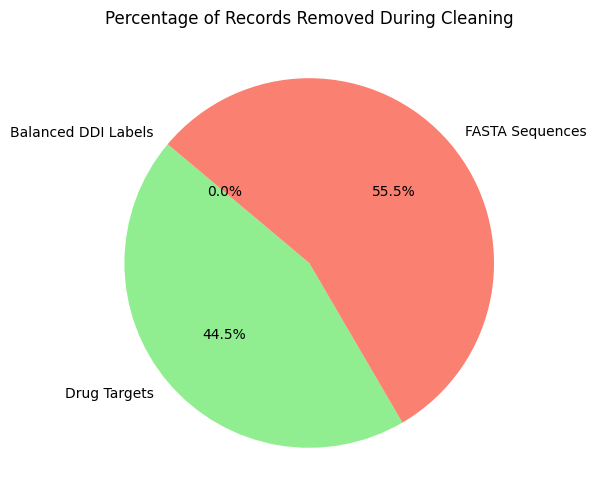

In [ ]:
import matplotlib.pyplot as plt

files = ["Balanced DDI Labels", "Drug Targets", "FASTA Sequences"]
before_counts = [before_ddi_count, before_drug_targets_count, before_fasta_count]
after_counts = [after_ddi_count, after_drug_targets_count, after_fasta_count]

# Data
removed_counts = [before_ddi_count - after_ddi_count,
                  before_drug_targets_count - after_drug_targets_count,
                  before_fasta_count - after_fasta_count]
total_counts = [before_ddi_count, before_drug_targets_count, before_fasta_count]

# Calculate percentages
percent_removed = [removed / total * 100 for removed, total in zip(removed_counts, total_counts)]

# Plot
plt.figure(figsize=(8, 6))
plt.pie(percent_removed, labels=files, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightgreen", "salmon"])
plt.title("Percentage of Records Removed During Cleaning")
plt.show()



## Dataset Record Counts: Before vs After Cleaning

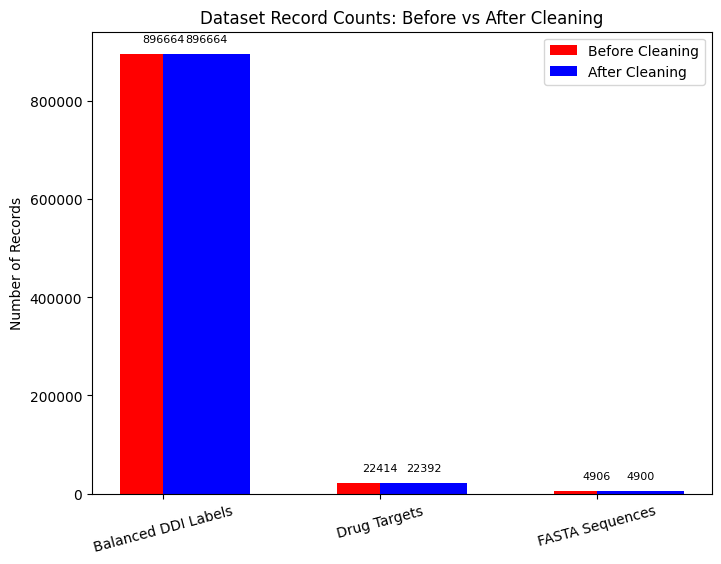

In [ ]:
import matplotlib.pyplot as plt

# Data (ensure these are correctly set in your code)
files = ["Balanced DDI Labels", "Drug Targets", "FASTA Sequences"]
before_counts = [before_ddi_count, before_drug_targets_count, before_fasta_count]
after_counts = [after_ddi_count, after_drug_targets_count, after_fasta_count]

# Plot
plt.figure(figsize=(8, 6))
x = range(len(files))
bar1 = plt.bar(x, before_counts, width=0.4, label="Before Cleaning", align="center", color="red")
bar2 = plt.bar(x, after_counts, width=0.4, label="After Cleaning", align="edge", color="blue")

# Add counts on top of the bars with better spacing
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,  # Add spacing
             f"{int(bar.get_height())}", ha="center", va="bottom", fontsize=8)
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,  # Add spacing
             f"{int(bar.get_height())}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, files, rotation=15)
plt.ylabel("Number of Records")
plt.title("Dataset Record Counts: Before vs After Cleaning")
plt.legend()
plt.show()

